NOTE: This notebook uses a JSON dictionary created by the `ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ADC_Saturation_Sample.py` script. As this notebook comprises of preliminary/diagnostic studies, the code may not be fully optimized. The code will be optimized in terms of runtime and organization as time permits. Please contact Elise Hinkle (ehinkle@uchicago.edu) with any questions, comments, or concerns. Also, all JSON dictionary file locations are likely outdated and should be changed based on where the user has chosen to store the relevant dictionary(ies).

In [1]:
# Import libraries and packages
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import h5py
import argparse
from datetime import datetime
import glob
import json
import cmasher as cmr
import math
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import sys
import os
import sys
sys.path.append('/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/event_display/LAr_evd/')
from lar2x2_evd import *
from collections import Counter

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Hello


In [2]:
# Open dictionary with ADC Saturation BEAM events (removing noisy channels identified using adc_saturation_event_initial_exploration.ipynb)
adc_sat_file = '/global/cfs/cdirs/dune/users/ehinkle/nd_prototypes_ana/2x2_sim/run-ndlar-flow/ndlar_flow/scripts/low_level_data_ana/charge_data_feature_studies/adc_saturation/ehinkle_personal_dicts_plots/adc_sat_dicts/adc_saturation_beam_events_V5_FINAL_REMOVAL_dict.json'
adc_sat_open = open(adc_sat_file)
adc_sat_dict = json.load(adc_sat_open)

In [3]:
# Make arrays of unique channels (iogroup is main IDs of interest) with ADC saturation packets, the number of ADC  
# saturation packets per unique channel, and energy deposited in the iogroup associated with the channel receiving the ADC saturation packet
unique_channels_with_adc_sat_packets = [adc_sat_dict[k]['unique_channels_impacted'] for k in adc_sat_dict.keys()]
unique_channels_counts = [adc_sat_dict[k]['total_sat_packets_per_unique_channel'] for k in adc_sat_dict.keys()]
unique_iog_with_adc_sat_packets = np.array([item[0] for sublist in unique_channels_with_adc_sat_packets for item in sublist])
channel_counts_with_adc_sat_packets = np.array([item for sublist in unique_channels_counts for item in sublist])

iog_negative_energy = [[adc_sat_dict[k]['iog_negative_energy']]*adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()]
iog_positive_energy = [[adc_sat_dict[k]['iog_positive_energy']]*adc_sat_dict[k]['num_adc_saturation_packets'] for k in adc_sat_dict.keys()]
single_adc_sat_packet_iog_pos_energy = np.array([item for sublist in iog_positive_energy for item in sublist])
single_adc_sat_packet_iog_neg_energy = np.array([item for sublist in iog_negative_energy for item in sublist])

iog_pos_energy = []
iog_neg_energy = []

# Separate LArPix-v2a and LArPix-v2b ASICs (for 2x2, iogroups 1,2,3,4,7,8 are v2a and iogroups 5,6 are v2b)
for i in range(len(unique_iog_with_adc_sat_packets)):
    iog = unique_iog_with_adc_sat_packets[i]
    if channel_counts_with_adc_sat_packets[i] == 1:
        iog_pos_energy.append(single_adc_sat_packet_iog_pos_energy[i][iog-1])
        iog_neg_energy.append(single_adc_sat_packet_iog_neg_energy[i][iog-1])

    else:
        iog_pos_energy.extend([single_adc_sat_packet_iog_pos_energy[i][iog-1]]*channel_counts_with_adc_sat_packets[i])
        iog_neg_energy.extend([single_adc_sat_packet_iog_neg_energy[i][iog-1]]*channel_counts_with_adc_sat_packets[i])

# Total event energy for events with ADC saturation packets
event_pos_energy_for_adc_sat_packets = np.array([adc_sat_dict[k]['total_positive_energy'] for k in adc_sat_dict.keys()])/1000 # Convert to GeV
event_neg_energy_for_adc_sat_packets = np.array([adc_sat_dict[k]['total_negative_energy'] for k in adc_sat_dict.keys()])/1000 # Convert to GeV
event_total_energy_for_adc_sat_packets = event_pos_energy_for_adc_sat_packets + event_neg_energy_for_adc_sat_packets


In [18]:
# Bin by event energy
pos_energy_bins = np.linspace(0, 50, 26)
total_energy_bins = np.linspace(-50, 50, 51)

event_pos_energy_bins = np.digitize(event_pos_energy_for_adc_sat_packets, pos_energy_bins)
event_total_energy_bins = np.digitize(event_total_energy_for_adc_sat_packets, total_energy_bins)

print("Max Event Positive Energy Bin:", max(event_pos_energy_bins))
print("Min Event Positive Energy Bin:", min(event_pos_energy_bins))
print("Max Event Total Energy Bin:", max(event_total_energy_bins))
print("Min Event Total Energy Bin:", min(event_total_energy_bins))

# Separate events by energy bin (get indices)
populated_pos_energy_bins = np.linspace(np.min(event_pos_energy_bins), np.max(event_pos_energy_bins), (np.max(event_pos_energy_bins) - np.min(event_pos_energy_bins) + 1))
populated_total_energy_bins = np.linspace(np.min(event_total_energy_bins), np.max(event_total_energy_bins), (np.max(event_total_energy_bins) - np.min(event_total_energy_bins) + 1))

Max Event Positive Energy Bin: 10
Min Event Positive Energy Bin: 1
Max Event Total Energy Bin: 33
Min Event Total Energy Bin: 23


In [19]:
# Function for getting datawords for relevant events to make histogram of datawords in energy bins

def dw_dist_in_subset_of_events(events_subset):
    dw_dist = []
    for i in range(len(events_subset[0])):
        event_key = list(adc_sat_dict.keys())[events_subset[0][i]]
        filepath = adc_sat_dict[event_key]['filepath']
        event_id = adc_sat_dict[event_key]['event_id']
        with h5py.File(filepath, 'r') as f:

            hits_ref = f['charge/events/ref/charge/calib_prompt_hits/ref']
            hits_region = f['charge/events/ref/charge/calib_prompt_hits/ref_region']
            packets_full = f['charge/packets/data']
            packets_ref = f['charge/calib_prompt_hits/ref/charge/packets/ref']

            hit_ref = hits_ref[hits_region[event_id,'start']:hits_region[event_id,'stop']]
            hit_ref = np.sort(hit_ref[hit_ref[:,0] == event_id, 1])
            packet_ref = packets_ref[hit_ref]
            packet_ref = np.sort(packet_ref[:, 1])
            packets = packets_full[packet_ref]
            data_packets = packets[packets['packet_type']==0]
            dw_dist.extend(data_packets['dataword'])

    return np.array(dw_dist)


Number of Rows: 4
Number of Columns: 3
Number of Rows: 4
Number of Columns: 3
Number of Rows: 4
Number of Columns: 3
Number of Rows: 4
Number of Columns: 3


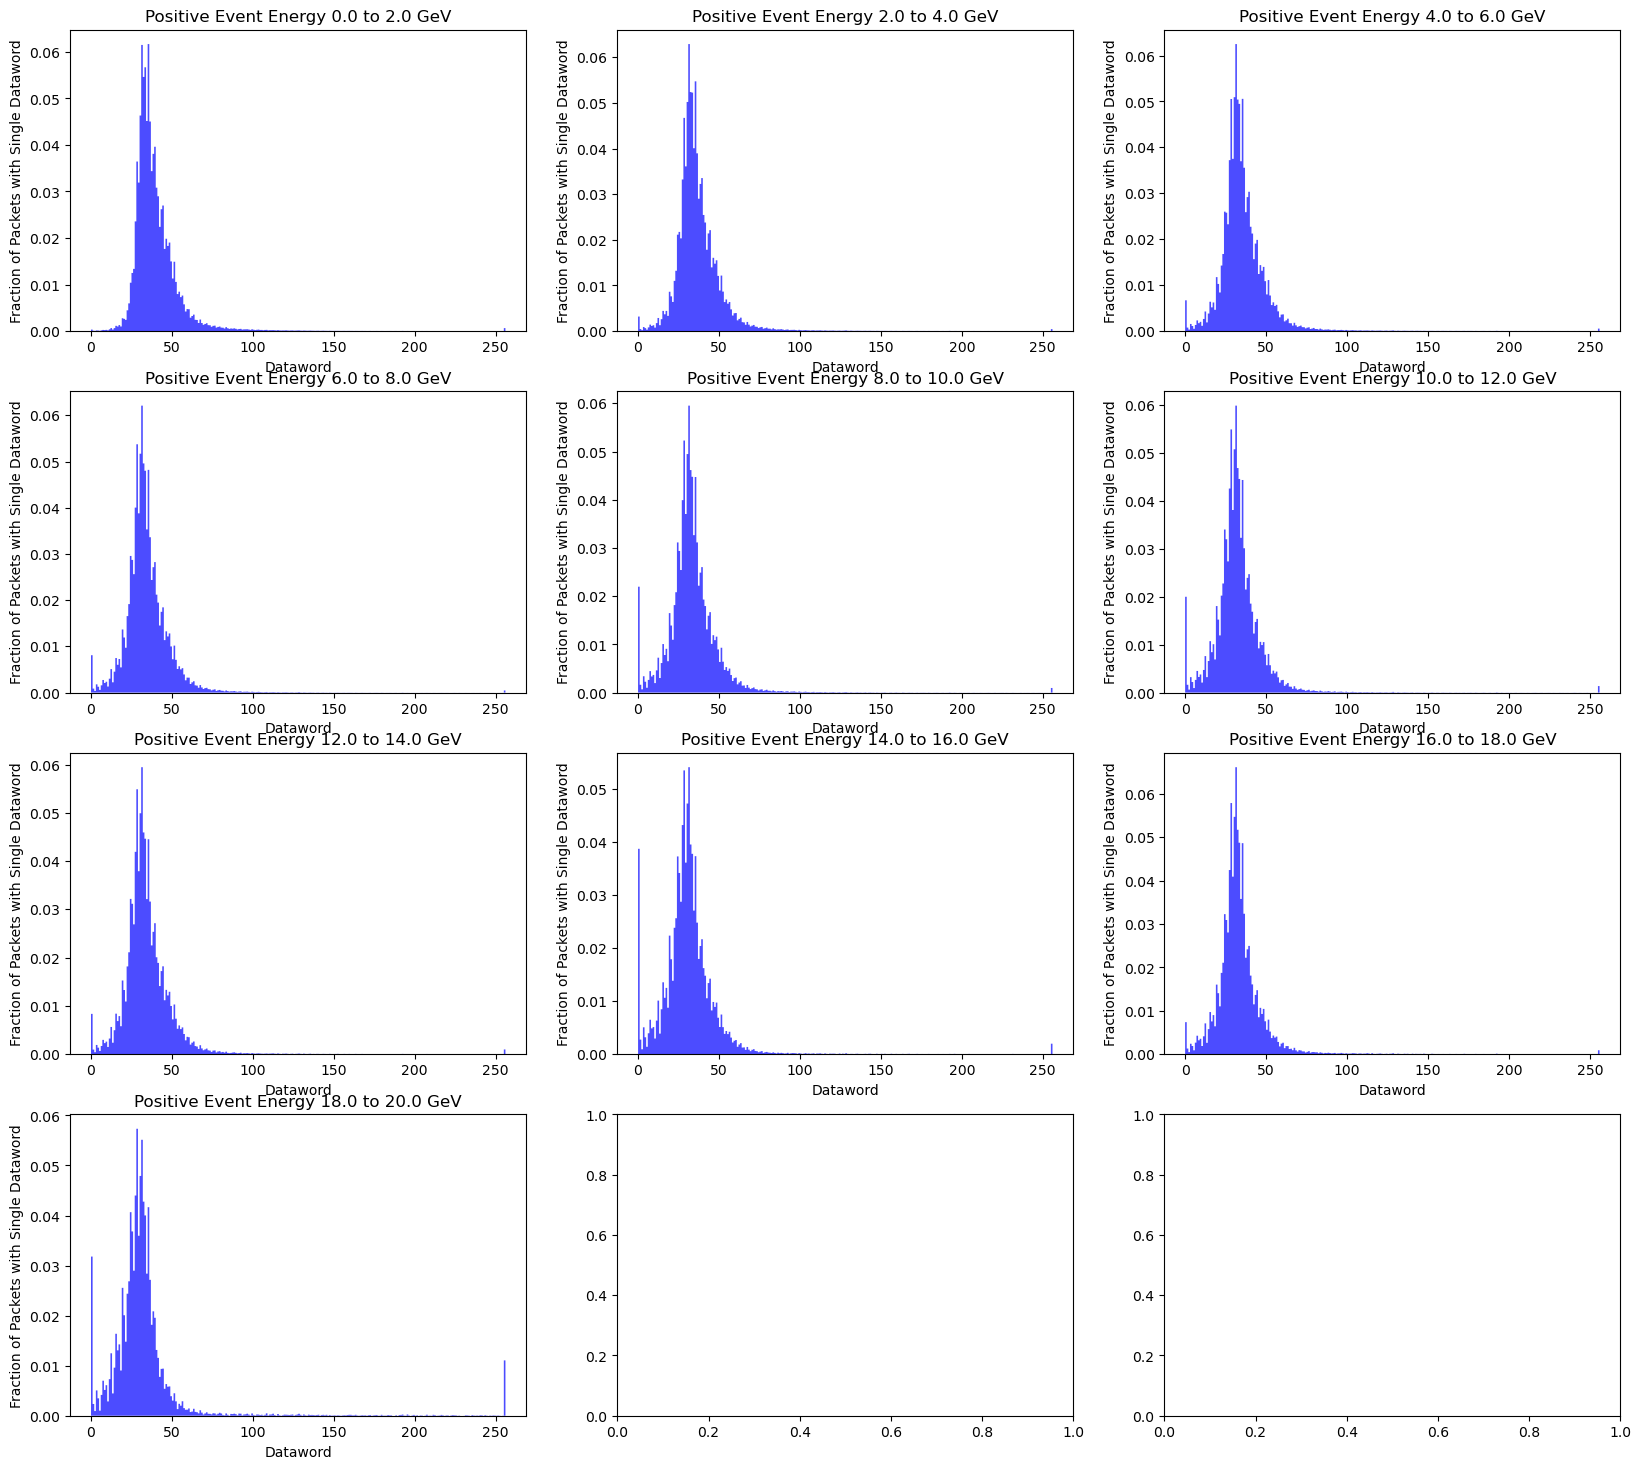

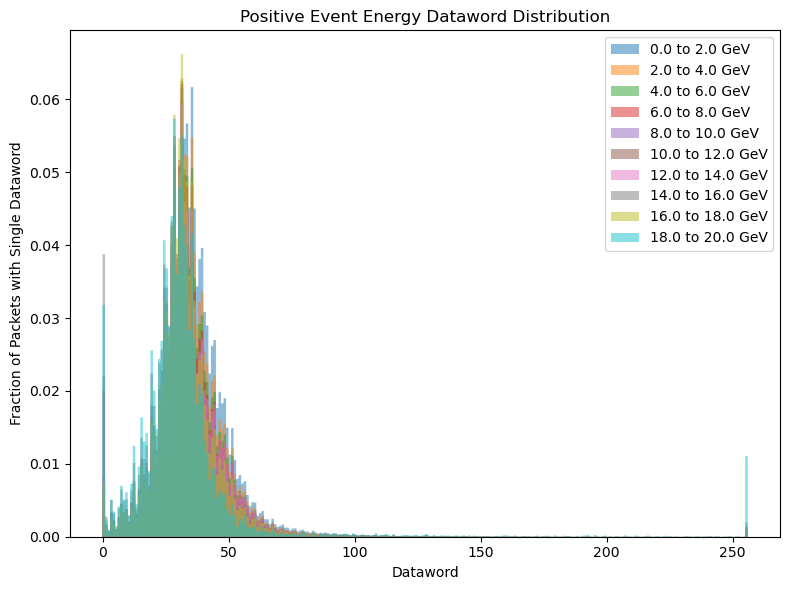

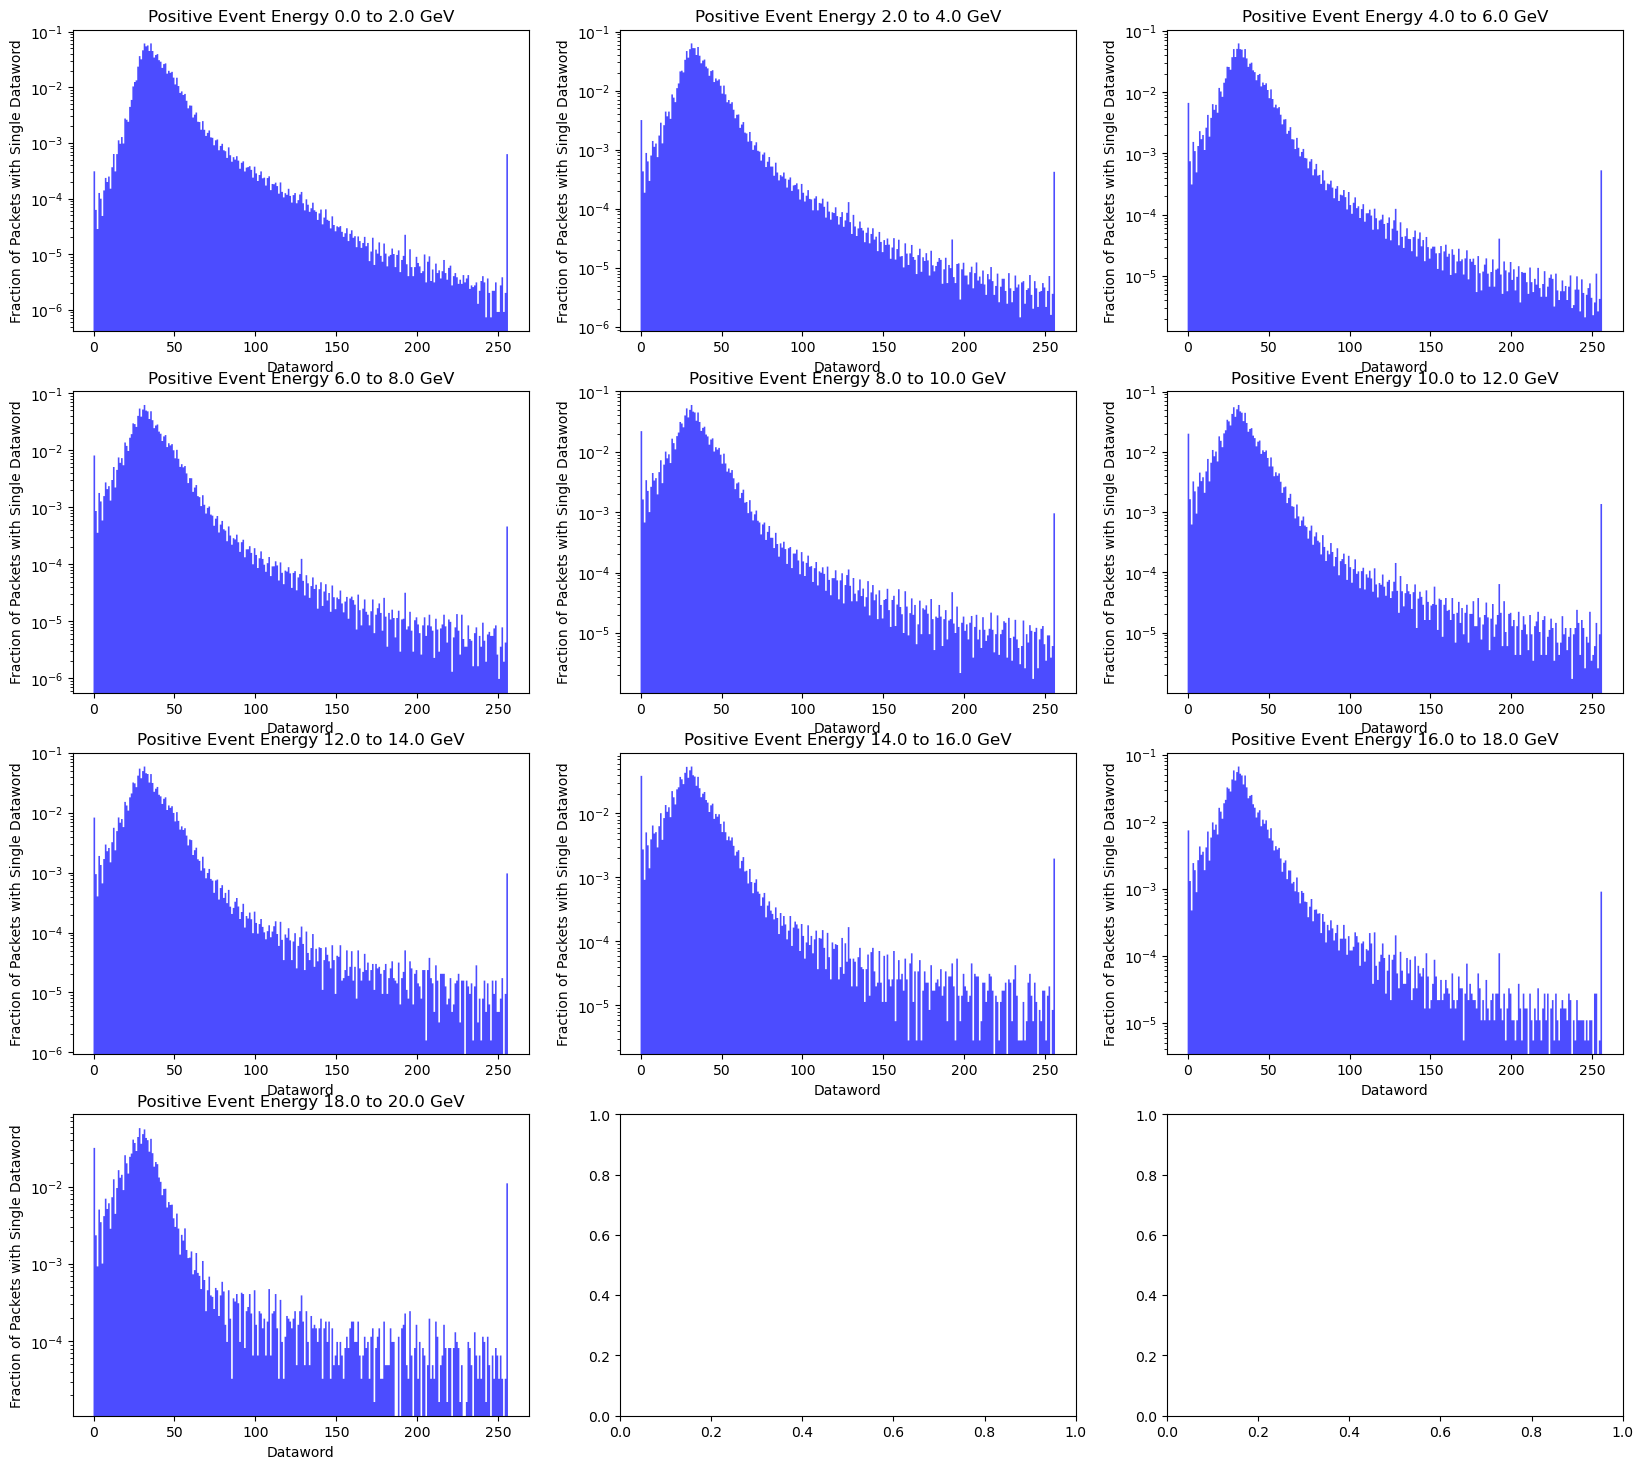

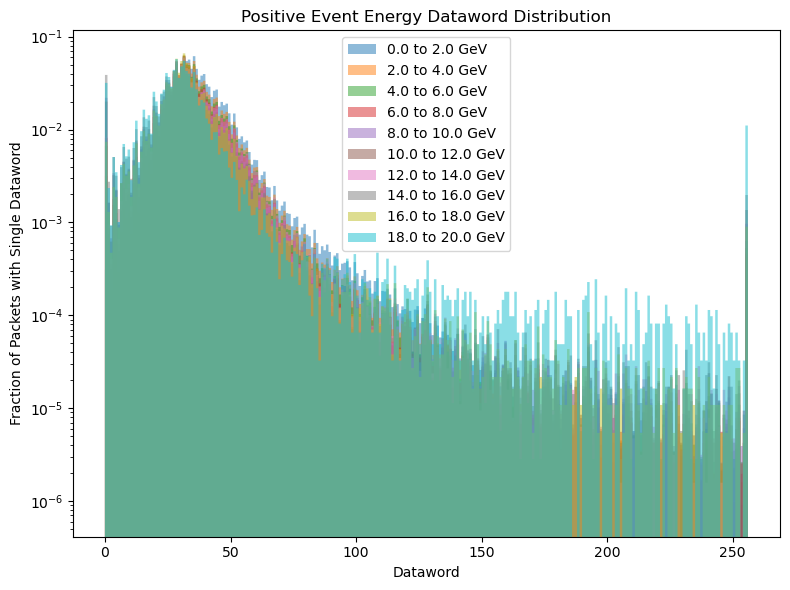

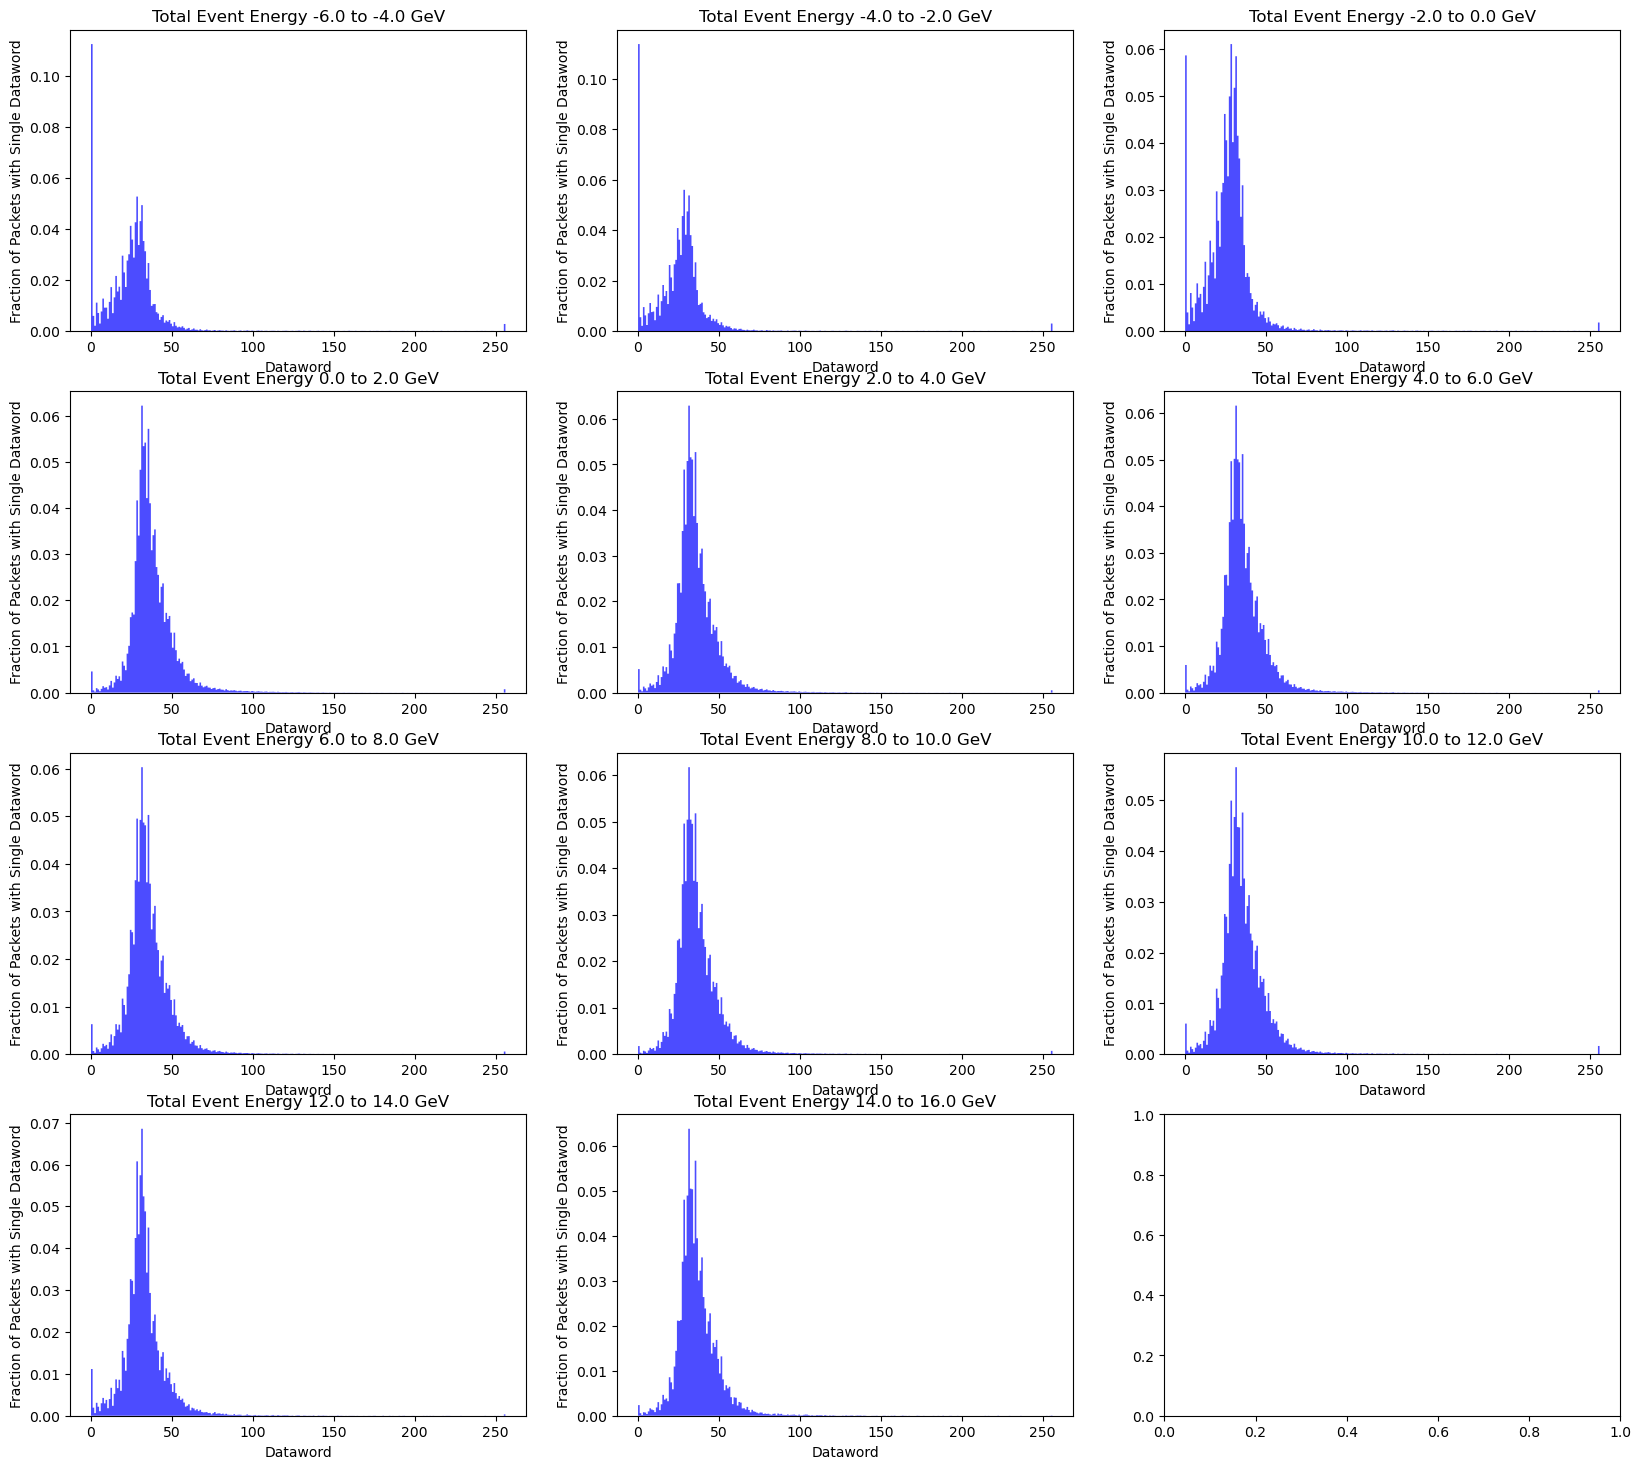

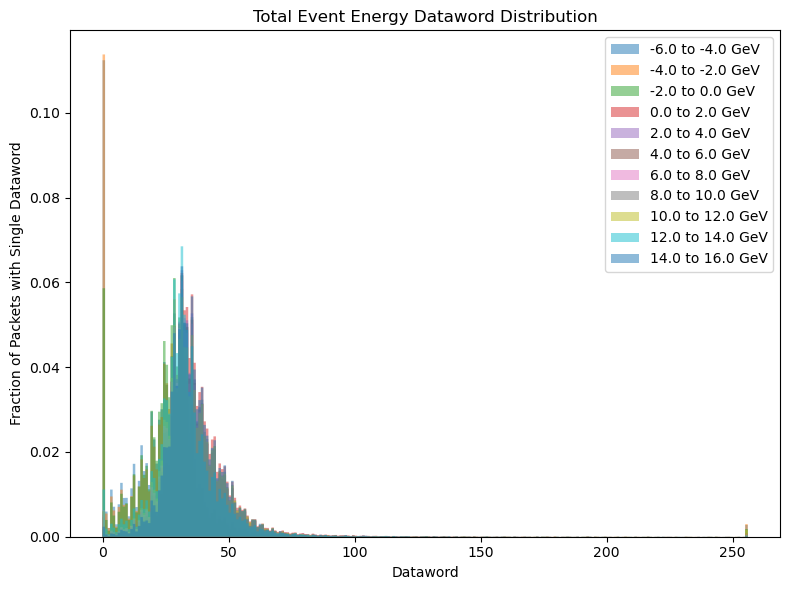

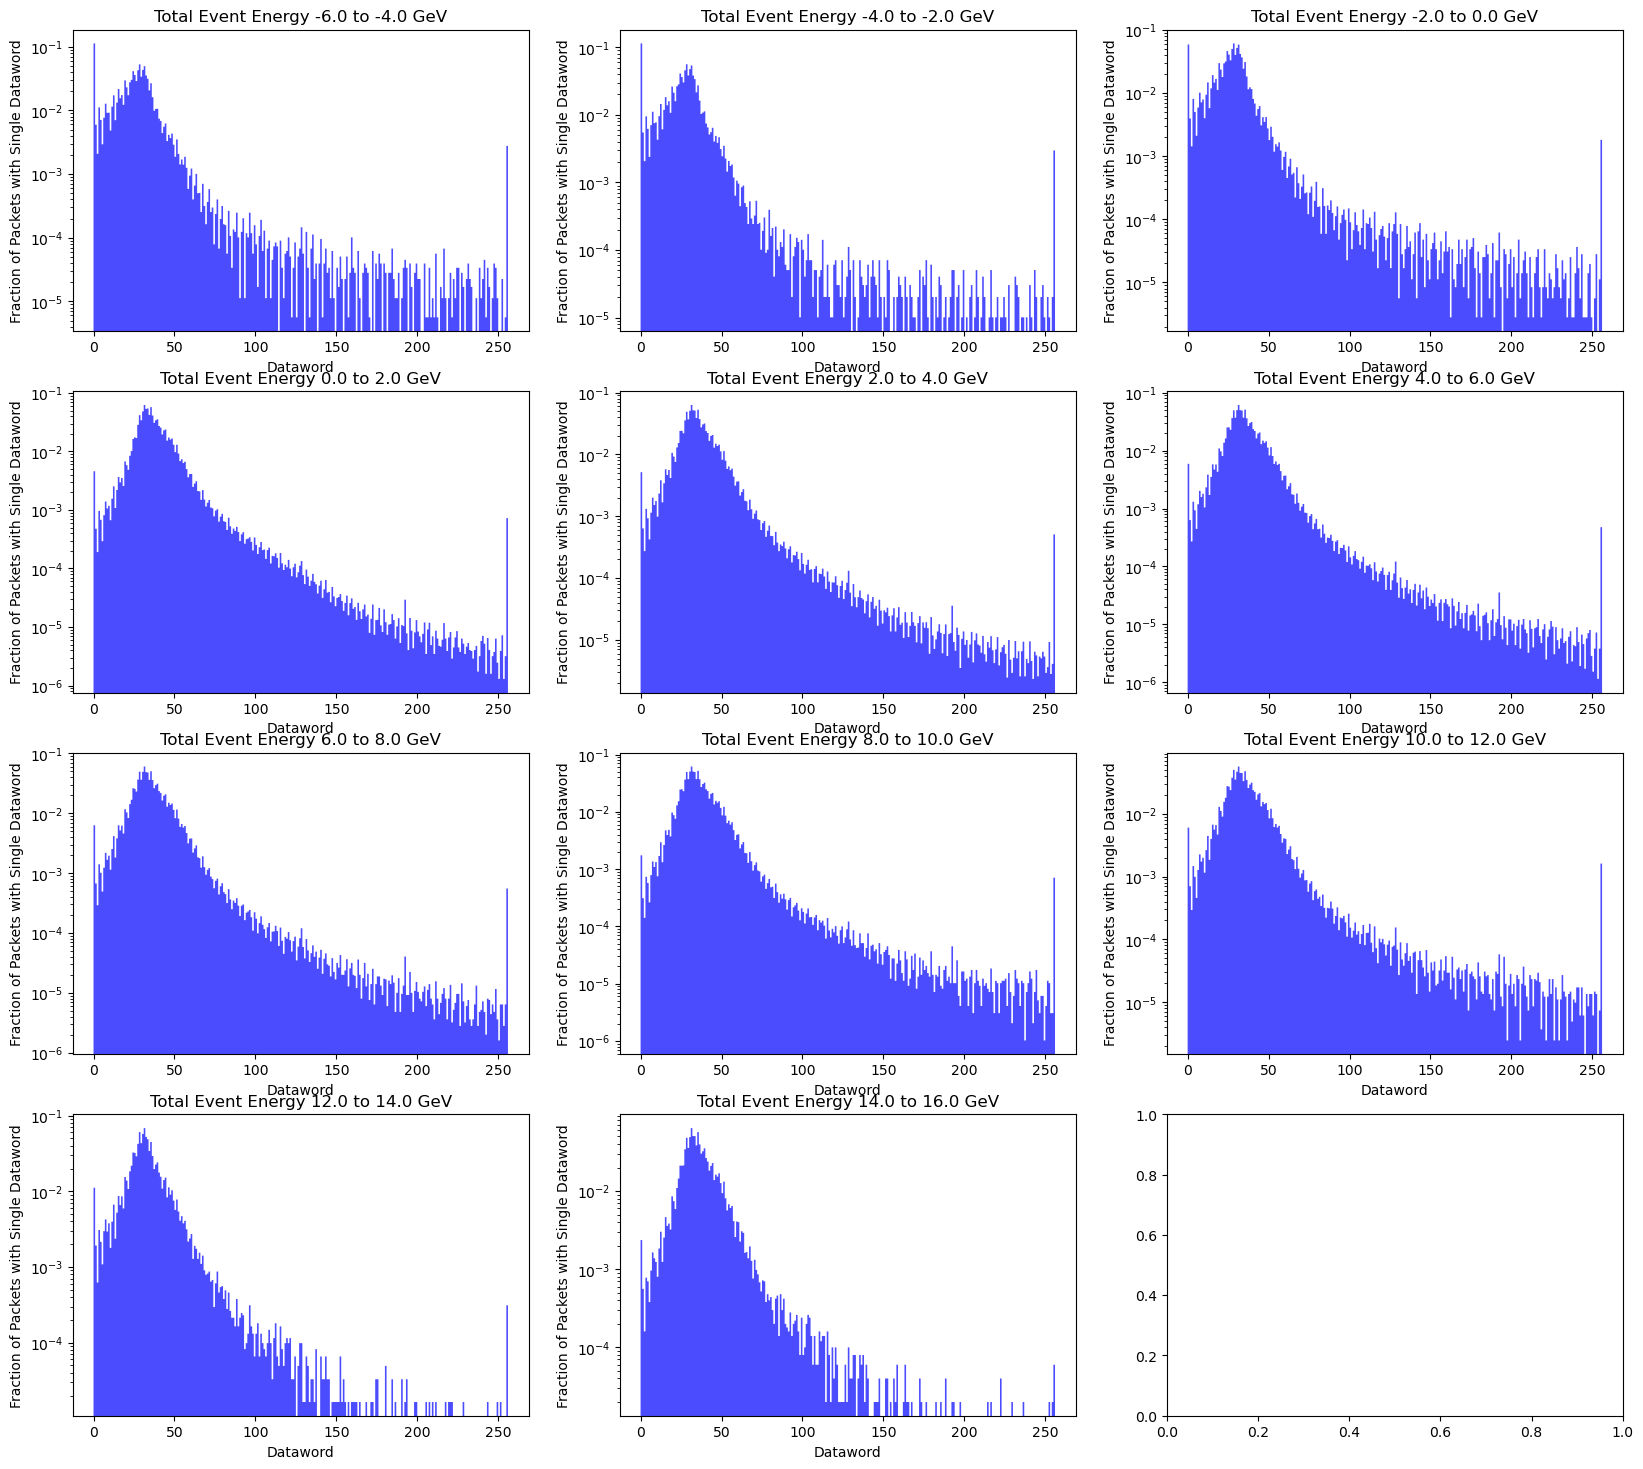

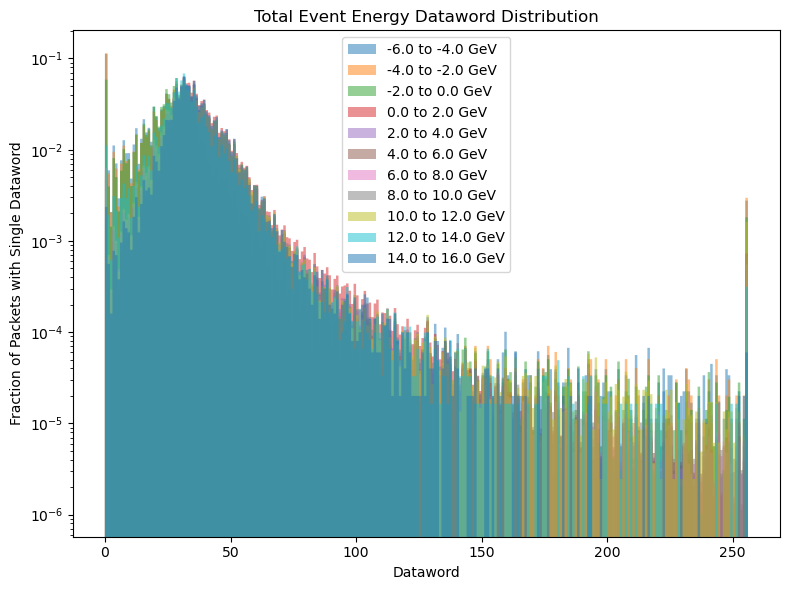

In [30]:
# Get plots for set of energy bins

def plot_dataword_dist_in_energy_bins(event_energy_bins, energy_bin_indices, full_energy_bins, energy_type, log):

    num_bins = len(energy_bin_indices)
    cols = 3
    rows = num_bins//cols + 1
    print("Number of Rows:", rows)
    print("Number of Columns:", cols)

    fig, axs = plt.subplots(rows, cols, figsize=(cols*6+2,rows*4+2))
    fig2, axs2 = plt.subplots(1,1, figsize=(8,6))


    for i in range(num_bins):

        row = i//cols
        col = i%cols

        events_subset = np.where(event_energy_bins == energy_bin_indices[i])
        event_bin_max_value = full_energy_bins[int(energy_bin_indices[i])]
        event_bin_min_value = full_energy_bins[int(energy_bin_indices[i]-1)]
        dw_dist = dw_dist_in_subset_of_events(events_subset)

        dw_dist_counts, dw_dist_bins = np.histogram(dw_dist, bins=256, range=(0, 256))

        # Plot separated histograms of datawords
        axs[row, col].hist(dw_dist_bins[:-1], bins=dw_dist_bins, weights=dw_dist_counts/len(dw_dist), color='blue', alpha=0.7, histtype='stepfilled')
        axs[row, col].set_title(f'{energy_type} {event_bin_min_value} to {event_bin_max_value} GeV')
        axs[row, col].set_xlabel('Dataword')
        axs[row, col].set_ylabel('Fraction of Packets with Single Dataword')

        # Plot combined histogram of datawords
        axs2.hist(dw_dist_bins[:-1], bins=dw_dist_bins, weights=dw_dist_counts/len(dw_dist), alpha=0.5, histtype='stepfilled', label=f'{event_bin_min_value} to {event_bin_max_value} GeV')
        axs2.set_title(f'{energy_type} Dataword Distribution')
        axs2.set_xlabel('Dataword')
        axs2.set_ylabel('Fraction of Packets with Single Dataword')
        axs2.legend()

        if log:
            axs[row, col].set_yscale('log')
            axs2.set_yscale('log')

    plt.tight_layout()
        
plot_dataword_dist_in_energy_bins(event_pos_energy_bins, populated_pos_energy_bins, pos_energy_bins, 'Positive Event Energy', log=False)
plot_dataword_dist_in_energy_bins(event_pos_energy_bins, populated_pos_energy_bins, pos_energy_bins, 'Positive Event Energy', log=True)
plot_dataword_dist_in_energy_bins(event_total_energy_bins, populated_total_energy_bins, total_energy_bins, 'Total Event Energy', log=False)
plot_dataword_dist_in_energy_bins(event_total_energy_bins, populated_total_energy_bins, total_energy_bins, 'Total Event Energy', log=True)
